In [2]:
from brpylib import NsxFile
import os
import numpy as np
import matplotlib.pyplot as plt

import direct_neural_biasing as dnb

## read data

In [29]:
data_file = np.load('data/Patient2EEG.npy')
mrk_file = 'data/Patient02_OfflineMrk.mrk'
data = data_file[0]

In [30]:
np.shape(data)

(83220000,)

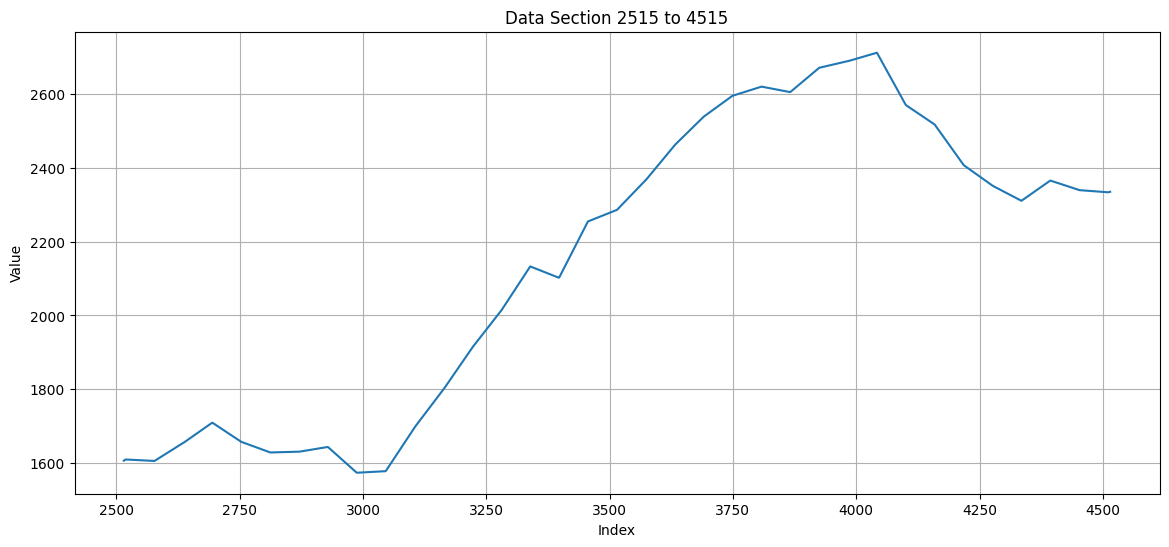

In [31]:
def plot_data_stream_section(data_stream, n, m):
    """
    Plots an n-m section of a 1D integer data stream as a line graph.

    Args:
        data_stream (list or numpy.ndarray): The 1D integer data stream.
        n (int): The starting index (inclusive).
        m (int): The ending index (inclusive).
    """
    section = data_stream[n : m + 1]
    indices = range(n, m + 1)

    plt.figure(figsize=(14, 6))
    plt.plot(indices, section)
    plt.title(f'Data Section {n} to {m}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

start_t = 2515
end_t = 4515

plot_data_stream_section(data, start_t, end_t)

In [32]:
# --- Concise .mrk file parser ---
def parse_mrk_file_concise(filepath):
    """
    Parses a .mrk file into a dictionary (signal_type: [indices]).
    Assumes first line is header, subsequent lines are 'index index signal_type'.
    """
    mrk_data = {}
    with open(filepath, 'r') as f:
        next(f) # Skip header line
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                index = int(parts[0])
                signal_type = parts[2]
                mrk_data.setdefault(signal_type, []).append(index)
    return mrk_data

def plot_marker_with_context(data_stream, marker_index, signal_type, context_window=500, output_dir="marker_plots"):
    """
    Plots a single marker with surrounding data context.
    """
    marker_index = marker_index * 512
    data_length = len(data_stream)
    plot_start = max(0, marker_index - context_window)
    plot_end = min(data_length - 1, marker_index + context_window)

    section_data = data_stream[plot_start : plot_end + 1]
    section_indices = range(plot_start, plot_end + 1)

    # CORRECTED LINE: Check if the section_data is empty using its length/size
    if len(section_data) == 0: # or if section_data.size == 0: if you're sure it's a numpy array
        print(f"Skipping plot for marker {marker_index} ({signal_type}) due to empty data section.")
        return

    plt.figure(figsize=(14, 6))
    plt.plot(section_indices, section_data, label='Continuous Data', color='blue', linewidth=1.5)

    # Highlight the marker point
    plt.axvline(x=marker_index, color='red', linestyle='--', label=f'Marker: {signal_type}')
    # Ensure the marker_index is within the bounds of data_stream before trying to access it
    if 0 <= marker_index < data_length:
        plt.plot(marker_index, data_stream[marker_index], 'ro', markersize=8, label='Marker Location')
    else:
        print(f"Warning: Marker index {marker_index} is out of bounds for data_stream. Cannot plot marker point.")


    plt.title(f'Signal Type: {signal_type} at Index: {marker_index} (Context: $\pm${context_window})')
    plt.xlabel('Data Index')
    plt.ylabel('Value')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    plt.close()


Parsed Markers:
  offlineSW: [3515, 7210, 7897, 14431, 16326]... (208 total)

Generating and displaying the first 10 plots with context window of $\pm$500...


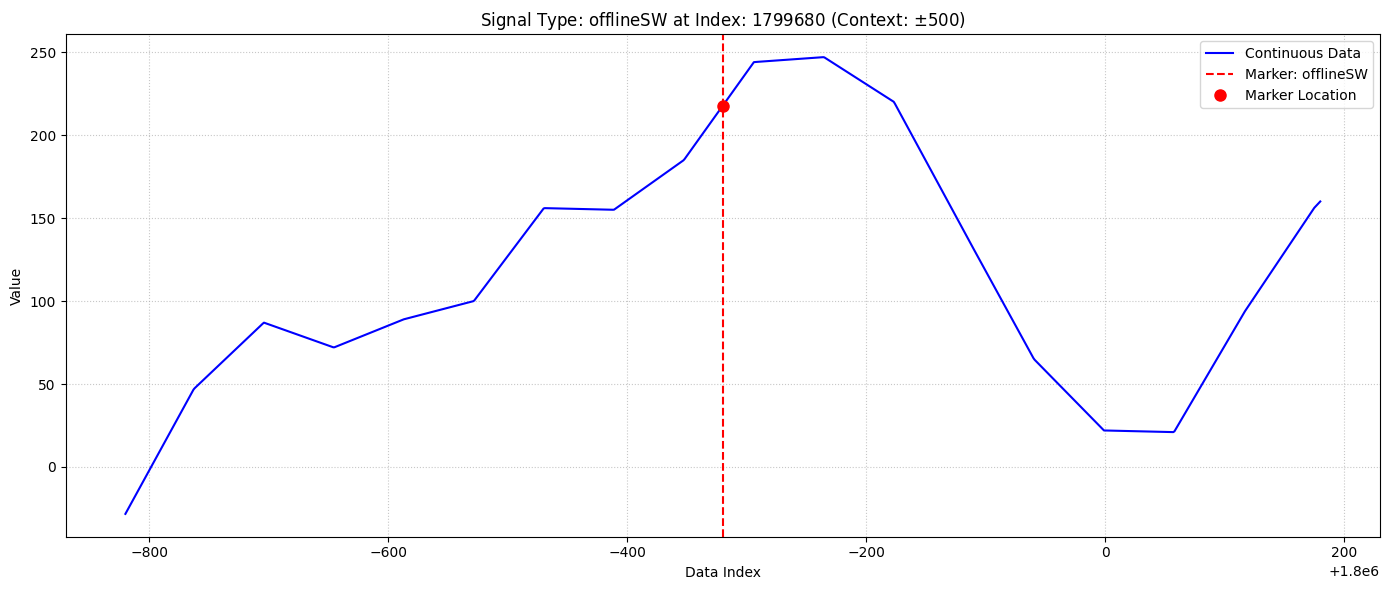

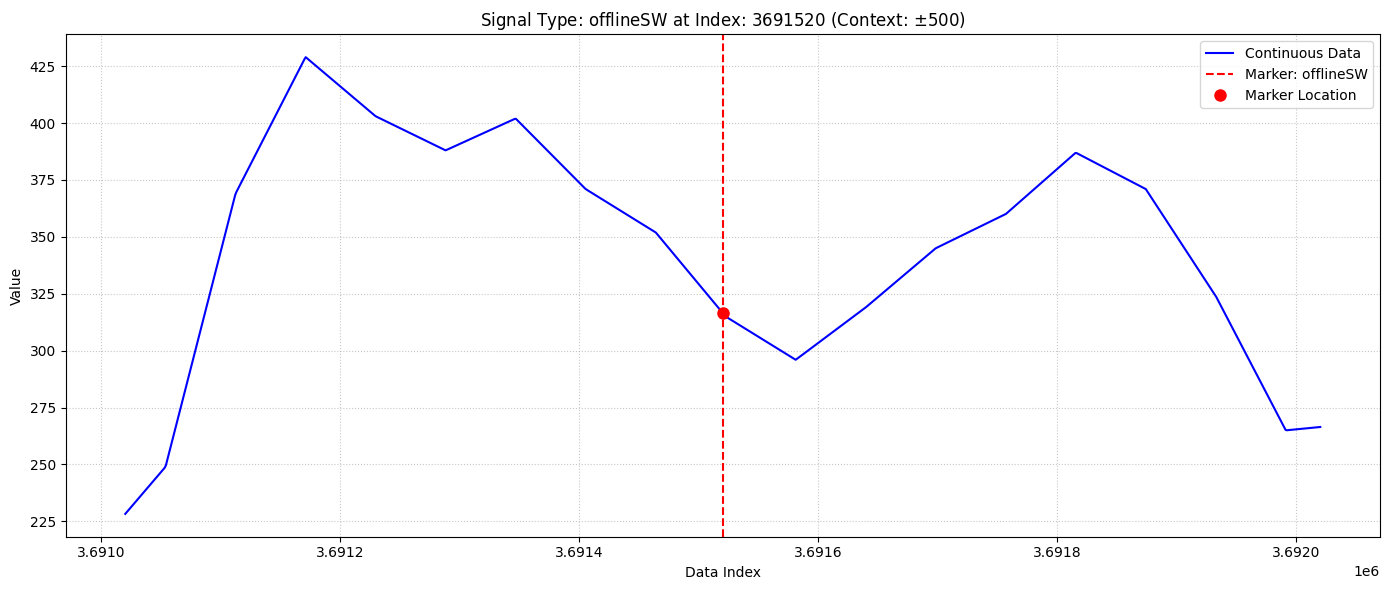

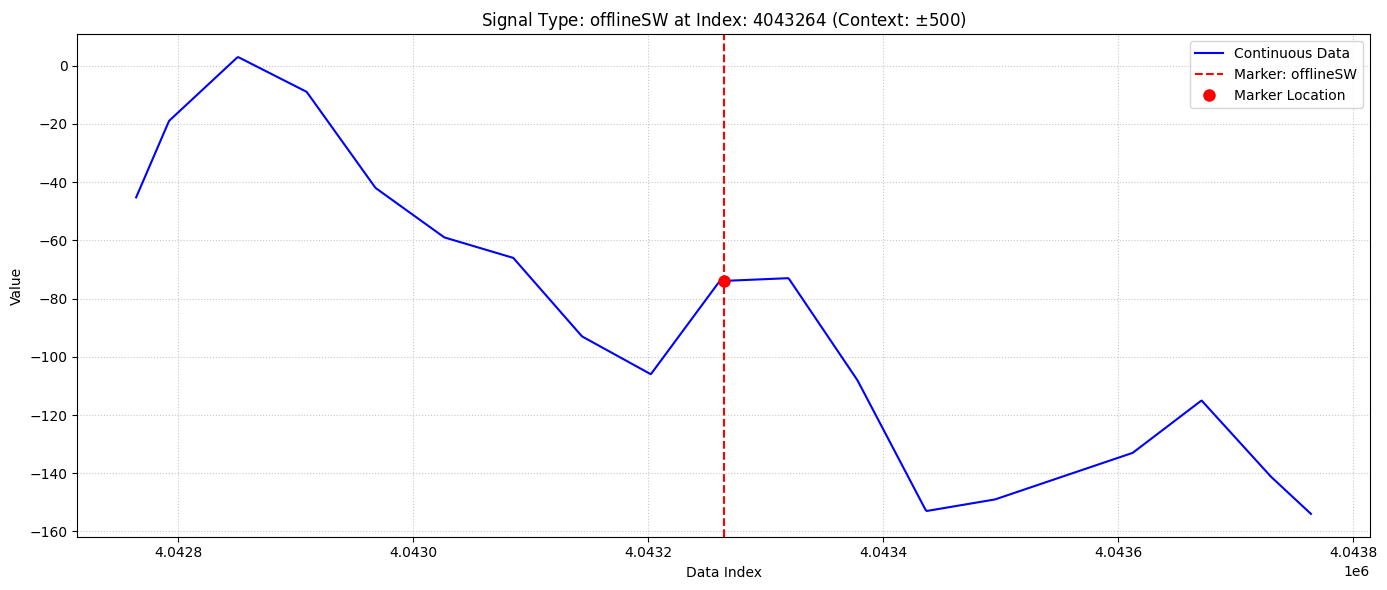

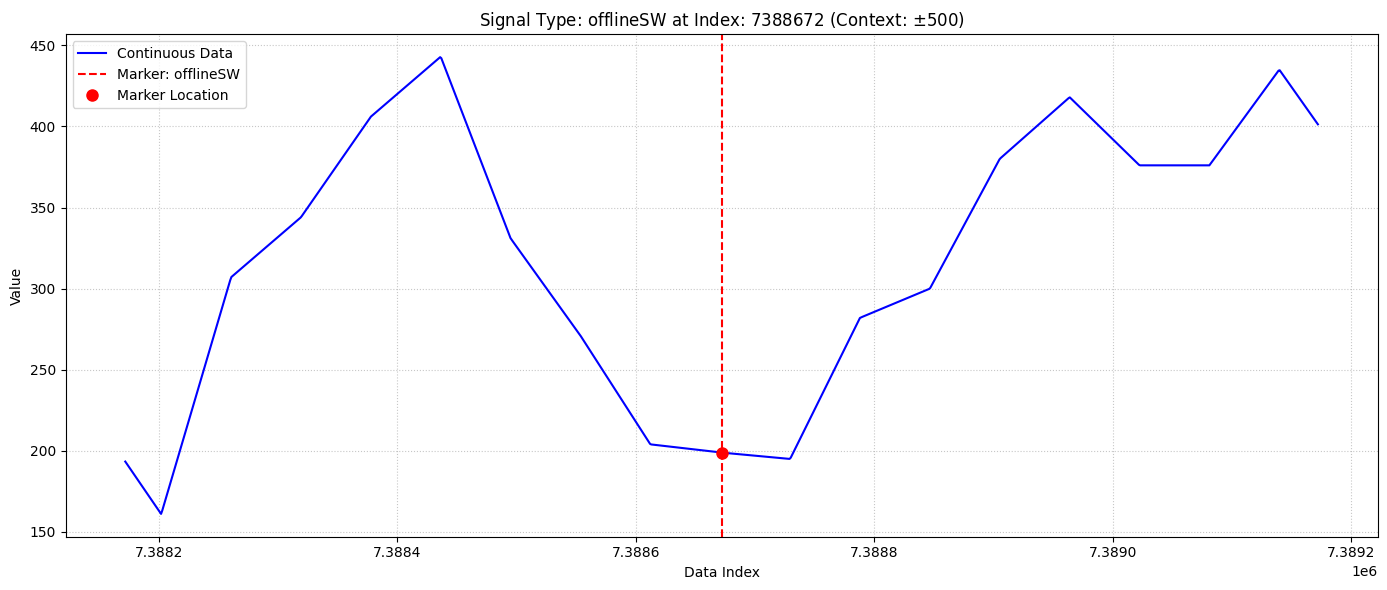

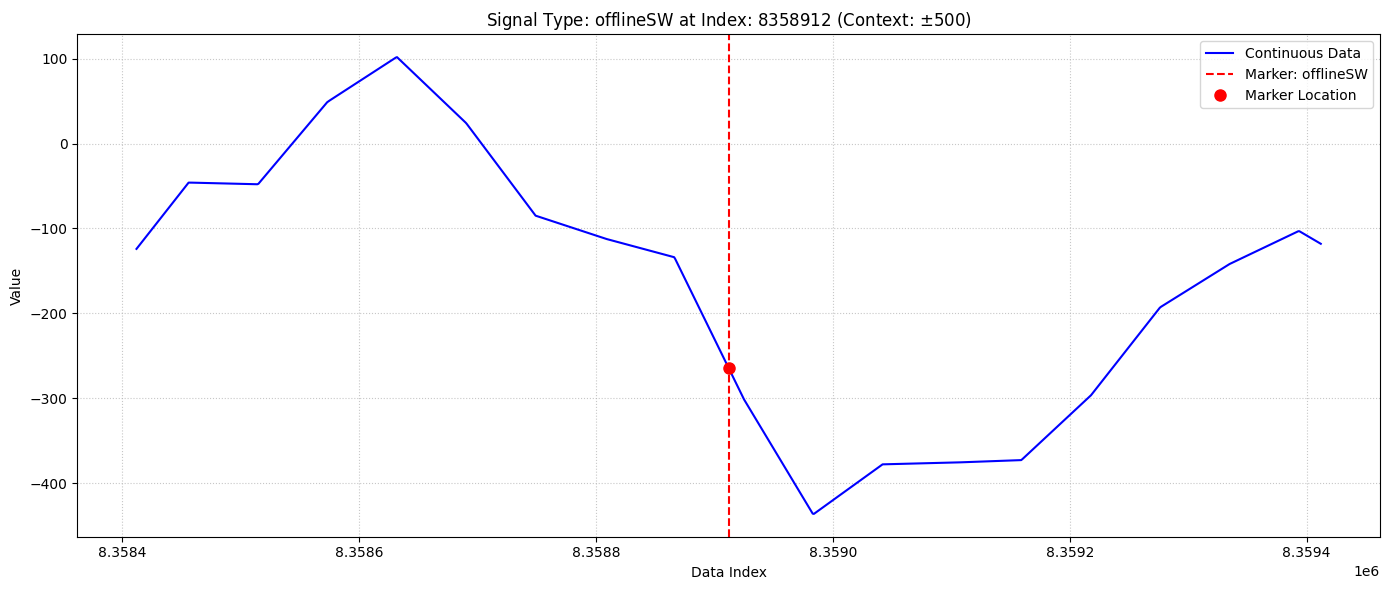

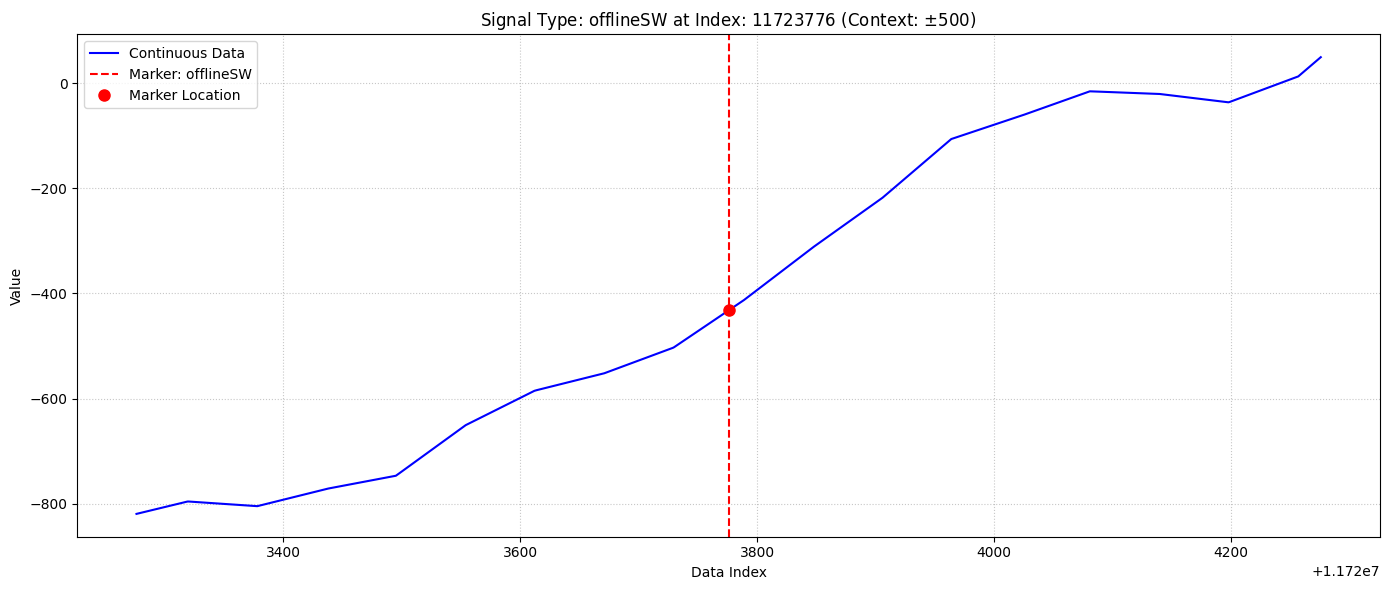

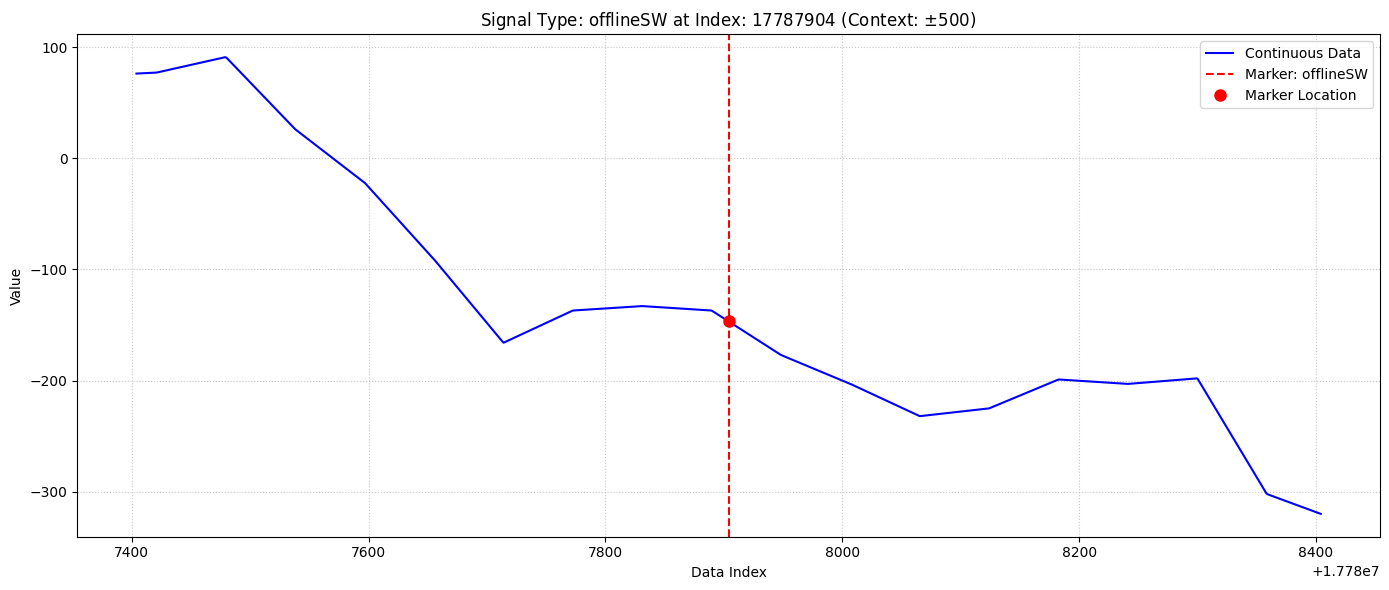

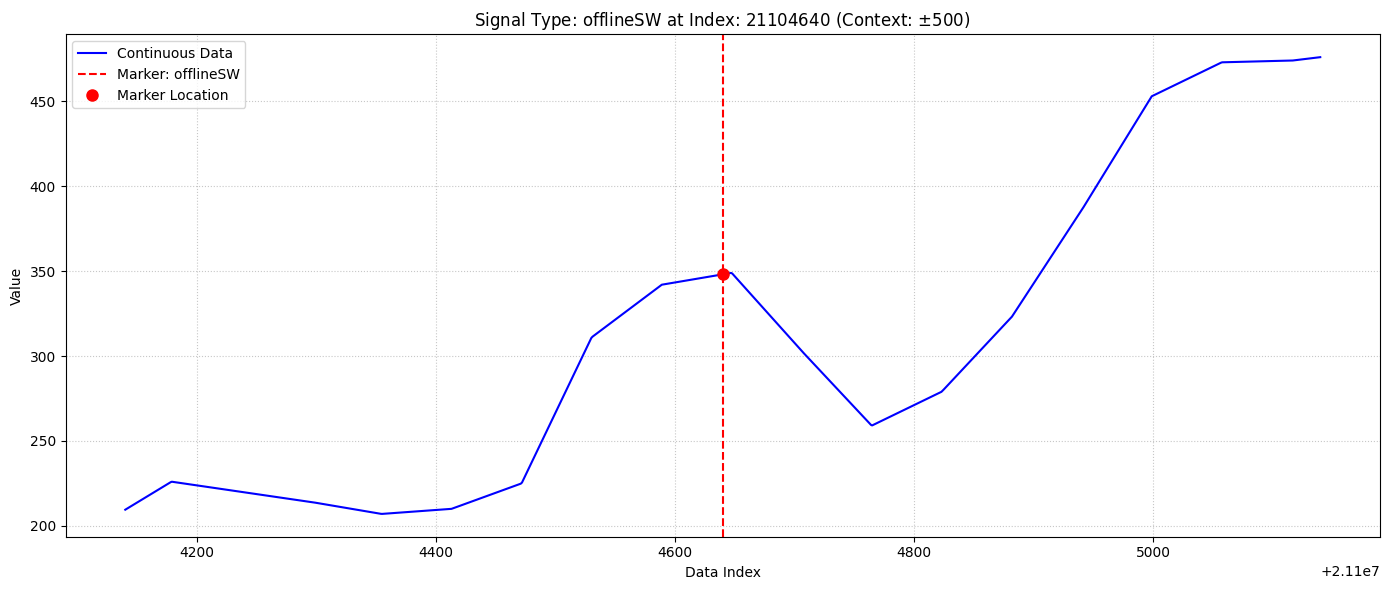

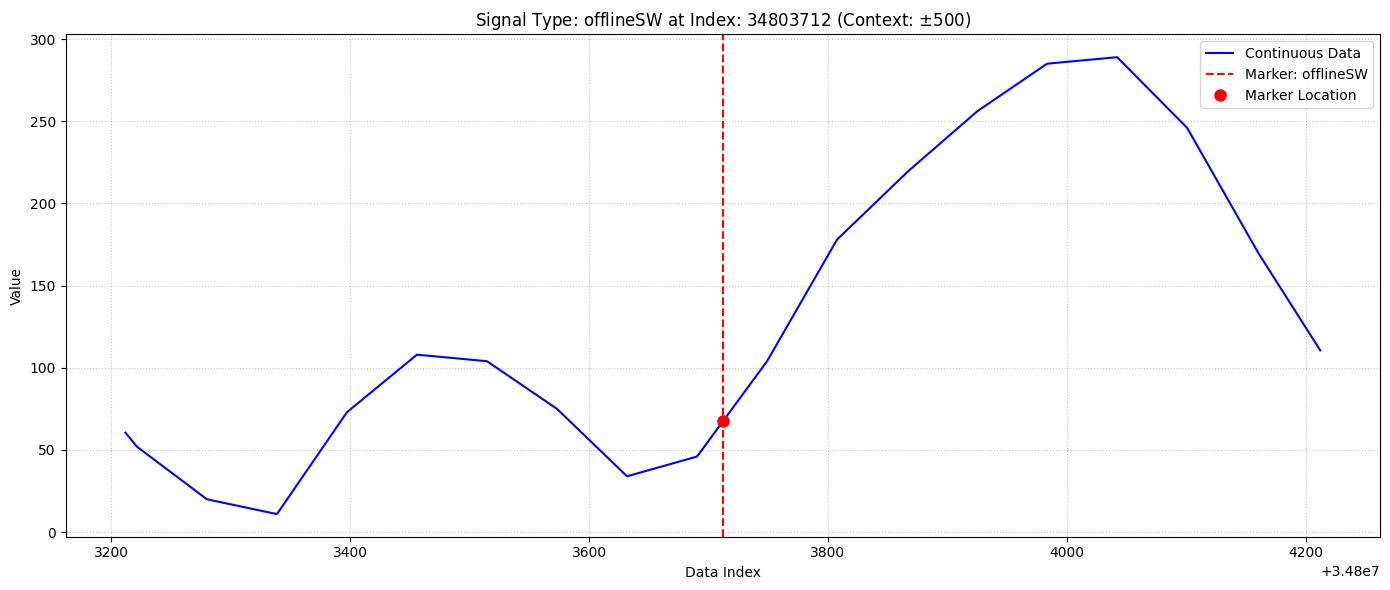

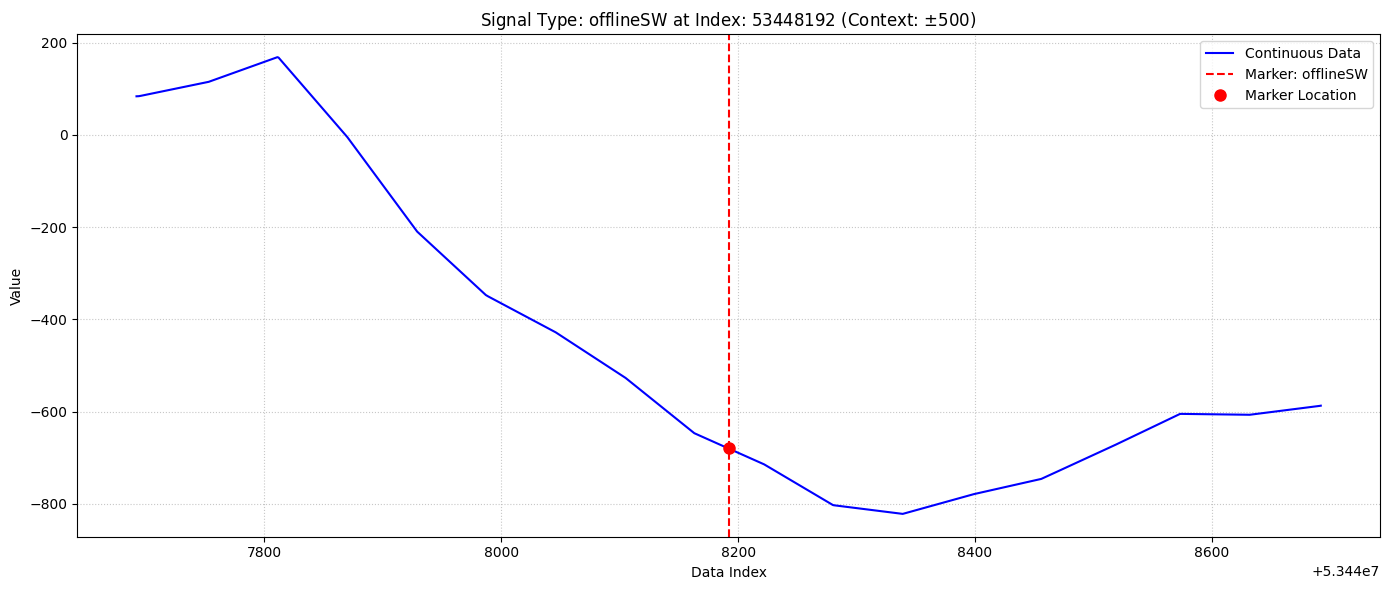


Finished displaying the first 10 marker plots.


In [33]:
# --- Main Execution ---

# 1. Parse the .mrk file
parsed_markers = parse_mrk_file_concise(mrk_file)
print("\nParsed Markers:")
for signal_type, indices in parsed_markers.items():
    print(f"  {signal_type}: {indices[:5]}... ({len(indices)} total)")

# 2. Plot each marker with context (first 10, show only)
context_window_size = 500 # Adjust this to change how much data is shown around each marker
max_plots_to_show = 10
plots_shown_count = 0

print(f"\nGenerating and displaying the first {max_plots_to_show} plots with context window of $\pm${context_window_size}...")

# Iterate through signal types and their indices
for signal_type, indices in parsed_markers.items():
    for marker_index in indices:
        if plots_shown_count < max_plots_to_show:
            plot_marker_with_context(data, marker_index, signal_type, context_window=context_window_size)
            plots_shown_count += 1
        else:
            # Once 10 plots are shown, break out of the inner loop
            break
    if plots_shown_count >= max_plots_to_show:
        # If 10 plots are shown, break out of the outer loop too
        break

if plots_shown_count == 0:
    print("No plots were generated. Check your .mrk file or data stream.")
else:
    print(f"\nFinished displaying the first {plots_shown_count} marker plots.")